# Project Proposal: Pulsar Classification
**DSCI 100 (007-34) Group Project Proposal**  
Group members:
- Elliot Saha
- Alasdair Buchanan
- Sarah Trevisan
- Minghao Li

## 1. Introduction

### 1.1 Background Information
Pulsars are high-magnetized neutron stars that spin at extremely fast speeds (Wikie). They emit radiation beams from their top and bottom. Because of these unique properties, astronomers can detect pulses of radiation as these beams sweep across earth. Since they are spinning with extremely consistent periods, pulsars are frequently used as independant clocks, allowing astronomers to observe fluctuations in spacetime. Despite their stable timing, these pulses can be quite difficult to distinguish from the large quantity of background radiation in space, making separating true pulsars from other candidates a challenging task.

### 1.2 Research Question
With the background information given, here is our research question:  
**How can we identify true pulsars in a dataset of pulsar candidates, given data about their emissions?**

### 1.3 Dataset

For this purpose, we will use [HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2) to perform classification for pulsar stars. HTRU2 dataset contains pulsar candidates collected during the HTRU survey.   

The dataset provides 8 columns of variables and 1 column of labels. For the 8 columns of the variables, there are 4 columns for statistical properties of integrated profile and 4 columns for the statistical properties of DM-SNR curve.  
- Integrated profile is a measure of the emission profile of the pulsar candidate, ie the 'size' of the pulse, expressed as a factor.
- DM-SNR curve is the ratio between the pulse and background radiation emissions.

## 2. Data analysis

### 2.1 Data Reading

In [1]:
# import tidyverse, repr, and tidymodels
library(tidyverse)
library(repr)
library(tidymodels)
# set random seed
set.seed(1111)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
pulsar_data <- read_csv("data/HTRU_2.csv", col_names=FALSE)
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


As we can see from the dataset, there are 8 distinct variables and 1 target label with 17,898 observations in total.

### 2.2 Data Wrangling

We noticed the data frame does not have proper column names and the type of the label column is incorrect. Therefore, we performed the following operations to clean the data.w

In [3]:
# rename the columns according to data/Readme.txt
pulsar_data <- pulsar_data |>
    rename(profile_mean = X1,
          profile_sd = X2,
          profile_kurtosis = X3,
          profile_skewness = X4,
          DM_SNR_mean = X5,
          DM_SNR_sd = X6,
          DM_SNR_kurtosis = X7,
          DM_SNR_skewness = X8,
          pulsar_star = X9) |> 
    drop_na() |>
    # mark the label column as a categorical variable
    mutate(pulsar_star = as_factor(pulsar_star)) |>
    # pulsar_star refers to if the row is a pulsar star or not
    mutate(pulsar_star = fct_recode(pulsar_star, "true" = "1", "false" = "0"))

head(pulsar_data)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,false
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,false
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,false
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,false
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,false


We divide the entire data set into a training part and a test part. The training set is 70% of the entire dataset, while the testing set takes the other 30%.

In [4]:
pulsar_split <- initial_split(pulsar_data, prop = 0.7, strata = pulsar_star)  
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)
head(pulsar_train)
head(pulsar_test)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,false
136.7500,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,false
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,false
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,false
107.2500,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,false
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,false


profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


### 2.3 Data Summary

In order to get more insights on the datasets, we first analyze the number of variables for classification.

In [5]:
dim(pulsar_train |>
    select(-pulsar_star))

[1] 12528     8

Therefore, we know there are 8 variables for classification, and there are 12528 observations in the training set.
Then, we calculate the number of observations in each particular class.

In [6]:
num_observations <- pulsar_train |>
    group_by(pulsar_star) |>
    summarize(num = n())
num_observations

pulsar_star,num
<fct>,<int>
false,11400
true,1128


In the training set, the category `false` has 11400 observations, while the category `true` only has 1128 observations. In this case, when we train the model, we need to be aware of the categorical imbalance in the dataset. We will resample the training set before we feed the data to the model.

### 2.4 Visualization


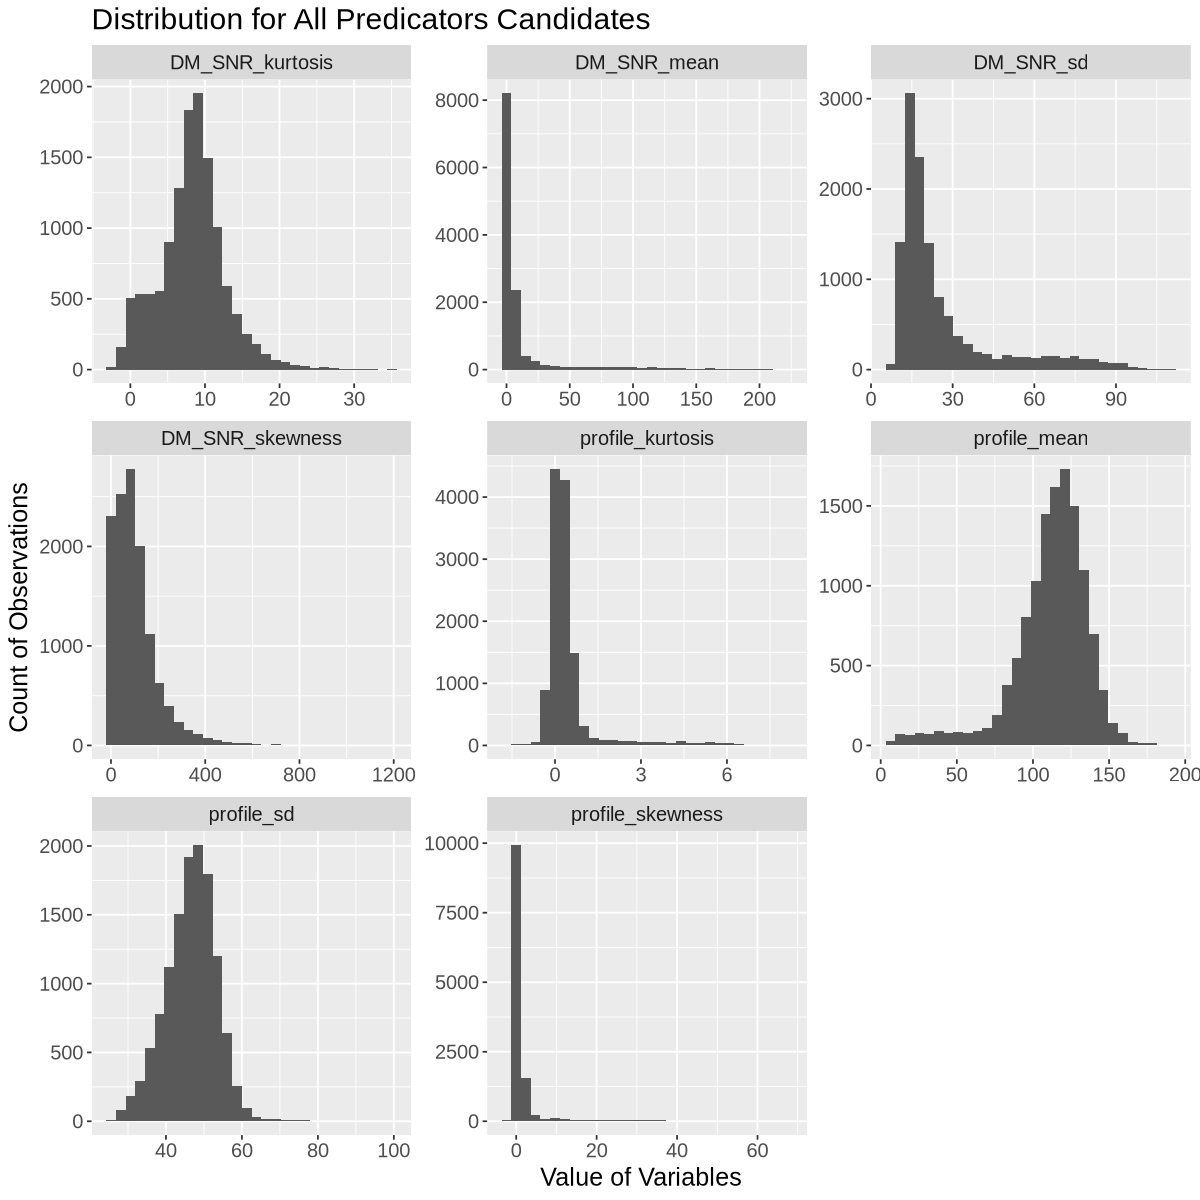

In [7]:
options(repr.plot.width = 10, repr.plot.height=10)
distribution_plot <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    ggplot(aes(x = value)) +
    geom_histogram(bins=30) +
    facet_wrap(vars(variable), scales = "free") +
    theme(text = element_text(size=15)) +
    labs(x = "Value of Variables", y = "Count of Observations") +
    ggtitle("Distribution for All Predicators Candidates")
distribution_plot

We visualize the distribution of all 8 predictor candidates. It is noticed that all these predictors are distributed in different shapes and they have different value ranges. Although the KNN model does not require a specific distribution of data, we still need to compress the data into a standard range by normalization.

## 3. Methods

## 4. Expected outcomes and significance

At the end of this report, we expect to have a model with a high accuracy considering the large amount of data we have. Considering the fact that we have more than 12 thousand rows of raw data in our training, we expect to end up with a relatively high precision and relatively high recall in our final predictive model. Our inputs for the models include the following: the mean, skewness, standard deviation, and excess kurtosis of the integrated profile and the DM-SNR curve. With these inputs, the model determines whether a star is possibly a pulsar star or not.

The precision timing of pulsar stars creates an extreme environment that could aid scientists in testing the limits of physics or testing different theories of gravity. Another significance of determing if stars are pulsars or not is the fact that the discovery of them could eventually lead to the discoery of new exoplanets which is relevant as it could help us answer the question of whether external life is present on other planets. 

## 5. Citations
R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty years of pulsar candidate selection: from simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society, Volume 459, Issue 1, 11 June 2016, Pages 1104–1123, https://doi.org/10.1093/mnras/stw656
--------- TODO: write this in APA

Wikimedia Foundation. (2024, March 7). Pulsar. Wikipedia. https://en.wikipedia.org/wiki/Pulsar 